# Formula learning

A toy example to learn a formula to predict a synthetic data


Let's say we have a regression problem to predict a target value in $\cal{R}$. 
Input data has $M$ features and a target is computed as 
$$
y_{i} = f(\mathbf x)
$$
we will try various functions $f$ to observe ability to learn it using a DNN.

## A warm-up

Let us predict a simple function : $f(\mathbf x) = 1 + \sum_{i} x_i$

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline


n_samples = 10000
n_features = 10
b = 1.0
x_max = 100.0
x_min = -100.0
trainval_x = (x_max - x_min) * np.random.rand(n_samples, n_features) + x_min

In [2]:
def f(x):
    return np.sum(x) + 1.0

In [3]:
trainval_y = np.zeros((n_samples, 1))
for i, x in enumerate(trainval_x):
    trainval_y[i, 0] = f(x)

In [4]:
import pandas as pd
import seaborn as sns

cols_x = ['x_%i' % i for i in range(n_features)]
df = pd.DataFrame(data=trainval_x, columns=cols_x)
df['y'] = trainval_y

In [5]:
df.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y
0,94.946815,-35.208120,-35.505545,-26.396494,-7.491188,71.858394,0.871778,-63.920196,48.865632,42.224185,91.245262
1,-75.404797,44.063781,-98.784467,-36.546104,6.644676,-50.757495,47.112068,-72.055855,-76.232885,-31.215638,-342.176717
2,-1.682601,3.144697,10.665782,99.203190,-21.970546,33.235633,26.480390,39.524516,10.340817,38.237186,238.179064
3,43.042179,-79.288446,11.354476,-10.804422,24.153784,-57.673734,-42.757828,-24.701784,28.554305,-24.009136,-131.130604
4,97.774933,-61.375933,-39.995264,64.766314,35.701705,55.633520,45.463148,-68.369833,40.886020,46.642266,218.126876


/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


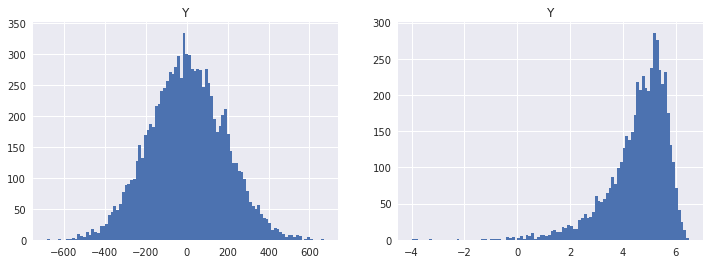

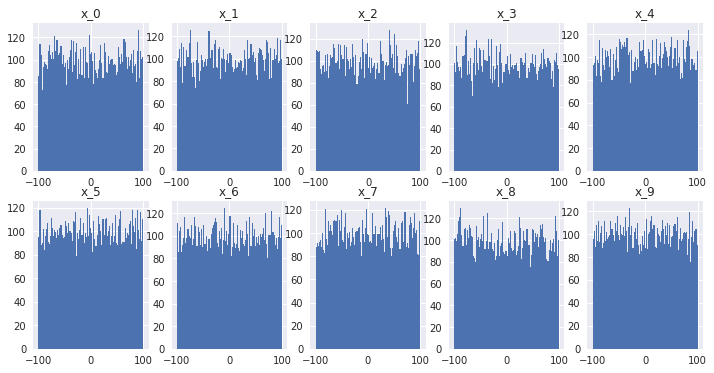

In [6]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
df['y'].hist(bins=100)
plt.title('Y')
plt.subplot(122)
df['y'].apply(np.log).hist(bins=100)
plt.title('Y')

plt.figure(figsize=(12, 6))
for i in range(n_features):
    plt.subplot(2, n_features/2, i+1)
    df['x_%i' % i].hist(bins=100)
    plt.title('x_%i' % i)

### Define a NN


Let's define a model as  
$$
f_{nn}(\mathbf x) = b_i + \langle W_i, \mathbf x \rangle,
$$

In [7]:
import tensorflow as tf

X = tf.placeholder("float", shape=(None, n_features))
Y = tf.placeholder("float", shape=(None, 1))

In [10]:
def nn(x):    
    b = tf.Variable(tf.random_uniform([1,]))
    W = tf.Variable(tf.random_normal([x.get_shape().as_list()[1], 1], mean=1.0, stddev=0.5))            
    return tf.add(b, tf.matmul(x, W))

In [15]:
train_params = {
    'learning_rate': 0.01,
    'training_epochs': 150,
    'batch_size': 64,
}

In [16]:
# Construct model and encapsulating all ops into scopes, making
# Tensorboard's Graph visualization more convenient
with tf.name_scope('Model'):
    # Model
    pred = nn(X)
    
with tf.name_scope('Loss'):
    # Minimize error using MAE
    loss = tf.reduce_mean(tf.abs(Y - pred))
    
with tf.name_scope('Optimizer'):
    # Gradient Descent
    optimizer = tf.train.GradientDescentOptimizer(train_params['learning_rate']).minimize(loss)
    
with tf.name_scope('RMSE'):
    # Accuracy    
    rmse = tf.sqrt(tf.reduce_mean(tf.square(Y - pred)))

# Create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# Create a summary to monitor accuracy tensor
tf.summary.scalar("RMSE", rmse)
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

In [17]:
display_step = 10

# Launch the graph
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())
    
    batch_size = train_params['batch_size']
    # Training cycle
    for epoch in range(train_params['training_epochs']):
        avg_loss = 0.
        
        total_batch = int(trainval_x.shape[0]/batch_size)
        
        # Loop over all batches
        for i in range(total_batch):
            i_start = batch_size*i
            i_end = batch_size*(i+1)
            batch_xs, batch_ys = trainval_x[i_start:i_end,:], trainval_y[i_start:i_end, :] 
            # Run optimization op (backprop), loss op (to get loss value)
            # and summary nodes
            _, c, summary = sess.run([optimizer, loss, merged_summary_op],
                                     feed_dict={X: batch_xs, Y: batch_ys})
            # Compute average loss
            avg_loss += c / total_batch
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            print("Epoch: '%04d', loss=%.9f" % (epoch+1, avg_loss))
            print("rmse: %f" % rmse.eval({X: batch_xs, Y: batch_ys}))

    print("Optimization Finished!")


Epoch: '0010', loss=13.346790109
rmse: 19.200865
Epoch: '0020', loss=13.325014808
rmse: 19.730783
Epoch: '0030', loss=13.029090903
rmse: 16.919834
Epoch: '0040', loss=13.486865481
rmse: 16.334917
Epoch: '0050', loss=13.531277308
rmse: 20.071470
Epoch: '0060', loss=13.335222198
rmse: 16.620750
Epoch: '0070', loss=13.007294517
rmse: 18.131403
Epoch: '0080', loss=13.203057738
rmse: 19.232840
Epoch: '0090', loss=13.171313974
rmse: 25.347588
Epoch: '0100', loss=13.175172304
rmse: 22.255545
Epoch: '0110', loss=13.538433420
rmse: 15.200148
Epoch: '0120', loss=13.529852818
rmse: 14.171961
Epoch: '0130', loss=13.130512268
rmse: 11.530375
Epoch: '0140', loss=13.399191667
rmse: 20.432739
Epoch: '0150', loss=13.167135321
rmse: 18.045624
Optimization Finished!


## A ratio-like and squared formula

Let $M=10$ and the function to learn is defined as 
$$
f(\mathbf x) = \frac{\sum_i a_i x_i + b} {\sum_i c_i x_i + d} + \alpha \sum_{i,j \neq i} x_i x_j + \beta
$$
where coefficients $a_i$, $b$, $c_i$, $d$, $\alpha$, $\beta$ are randomly chosen.

Setup input data :

In [3]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

n_samples = 10000
n_features = 10
a = np.random.rand(n_features)
b = 1.0
c = np.random.rand(n_features)
d = np.random.rand() * 100.0
alpha = np.random.rand() * 1.0 / 50.0
beta = np.random.rand() * 50.0

x_max = 100.0
x_min = -50.0
trainval_x = (x_max - x_min) * np.random.rand(n_samples, n_features) + x_min

In [4]:
def f(sample_x):
    numerator = np.dot(a, sample_x) + b
    denominator = np.dot(c, sample_x) + d
    t1 = numerator / denominator
    
    t2 = 0
    for v in sample_x:
        t2 += v * (np.sum(sample_x) - v)    
    t2 *= alpha
    return t1 + t2 + beta

In [62]:
trainval_y = np.zeros((n_samples, 1))
for i, x in enumerate(trainval_x):
    trainval_y[i] = f(x)

In [64]:
import pandas as pd
import seaborn as sns

cols_x = ['x_%i' % i for i in range(n_features)]
df = pd.DataFrame(data=trainval_x, columns=cols_x)
df['y'] = trainval_y

In [65]:
df.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y
0,40.425245,87.073970,-37.476818,40.503674,52.398057,65.812719,-34.195931,4.148323,56.190972,-23.843447,60.357144
1,-3.169449,-12.820580,76.330680,-15.900743,-48.068176,87.394782,30.073804,52.666001,58.815798,16.444855,55.289412
2,-20.572207,-3.650812,96.479582,-35.429151,-20.944052,89.106976,-18.394779,-30.838079,79.410738,-42.040173,-21.816756
3,91.229796,-8.355221,74.436617,-22.910272,13.607131,-8.946438,39.777513,85.133333,98.830541,37.519781,181.904713
4,97.344369,71.475973,36.655585,-48.061746,13.271403,23.655426,9.077755,45.041416,-39.383458,78.937506,84.623889


/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


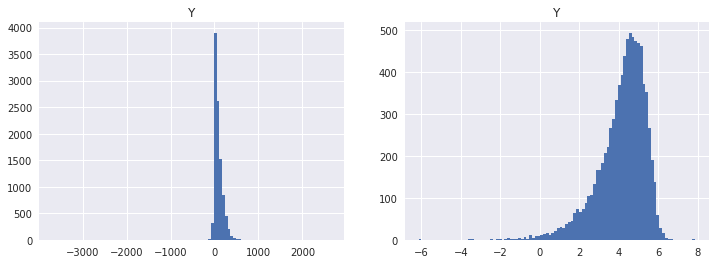

In [52]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
df['y'].hist(bins=100)
plt.title('Y')
plt.subplot(122)
df['y'].apply(np.log).hist(bins=100)
plt.title('Y')

# plt.figure(figsize=(12, 6))
# for i in range(n_features):
#     plt.subplot(2, n_features/2, i+1)
#     df['x_%i' % i].hist(bins=100)
#     plt.title('x_%i' % i)

### Define a NN


Let's define a model as  
$$
f_{nn}(\mathbf x) = \prod_{i=0}^{l-1} \left( b_i + \langle W_i, g(\mathbf x) \rangle \right),
$$
where 
$$
g(\mathbf x) = g_m(\mathbf x) = h^{(1)}_{m,m-1}(\mathbf x) + \frac{1}{\epsilon + h^{(2)}_{m,m-1}(\mathbf x)}
$$
and 
$$
h^{(i)}_{m,m-1}(\mathbf x) = \text{activation}(\langle W_{i,m}, g_{m-1}(\mathbf x) \rangle + b_{i,m}), \\
g_{0} (\mathbf x) = \mathbf x
$$


In [11]:
import pydot
from itertools import chain
def tf_graph_to_dot(in_graph):
    dot = pydot.Dot()
    dot.set('rankdir', 'LR')
    dot.set('concentrate', True)
    dot.set_node_defaults(shape='record')
    all_ops = in_graph.get_operations()
    all_tens_dict = {k: i for i,k in enumerate(set(chain(*[c_op.outputs for c_op in all_ops])))}
    for c_node in all_tens_dict.keys():
        node = pydot.Node(c_node.name)#, label=label)
        dot.add_node(node)
    for c_op in all_ops:
        for c_output in c_op.outputs:
            for c_input in c_op.inputs:
                dot.add_edge(pydot.Edge(c_input.name, c_output.name))
    return dot

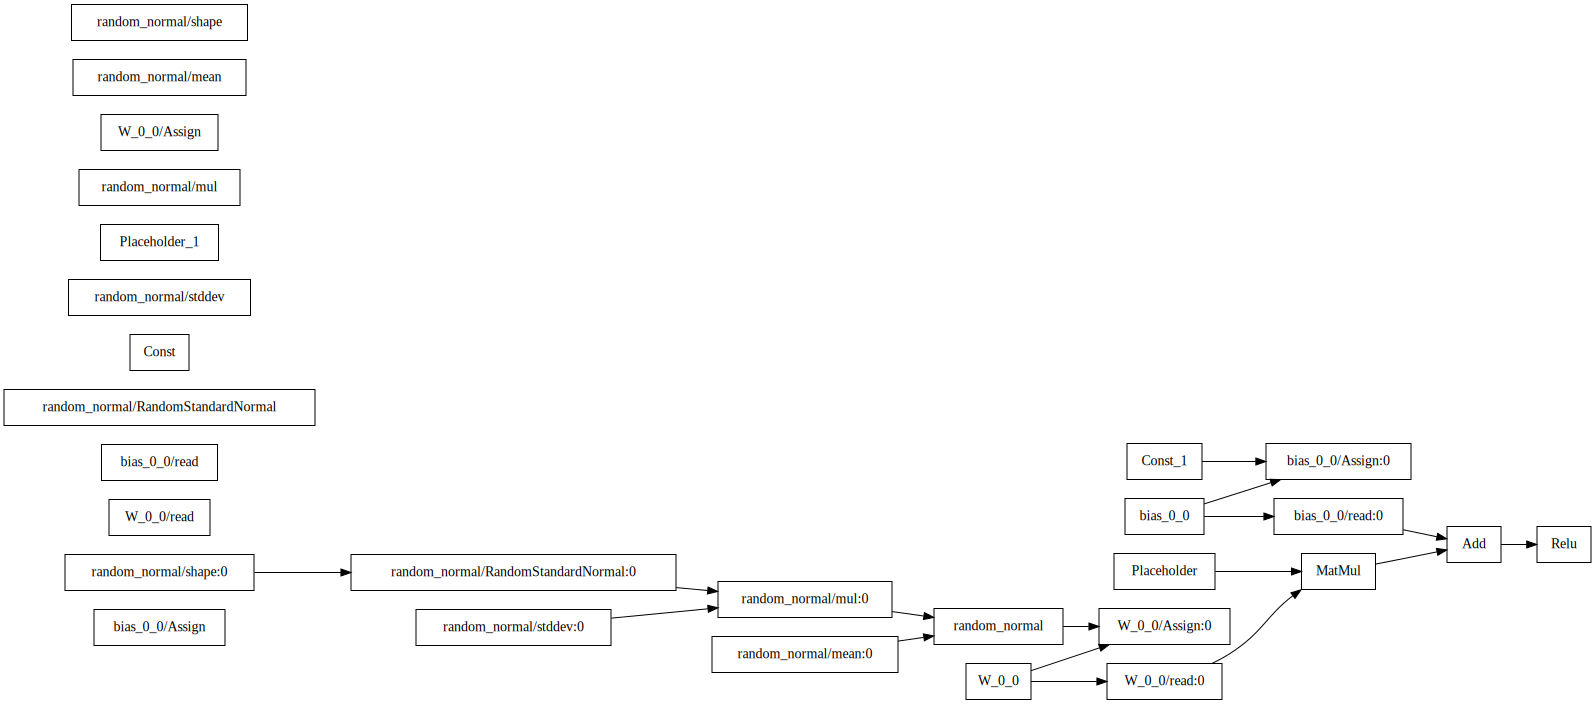

In [15]:
# from IPython.display import SVG
# # Define model
# tf_graph_to_dot(h_0_0.graph).write_svg('simple_tf.svg')
# SVG('simple_tf.svg')

In [9]:
import tensorflow as tf

In [10]:
X = tf.placeholder("float", shape=(None, n_features))
Y = tf.placeholder("float", shape=(None, 1))

In [45]:
epsilon = tf.constant(1e-10)

def h(index, m, x, n_filters, with_activation=True):    
    b = tf.Variable(tf.random_normal([n_filters]), 
                    name='bias_%i_%i' % (index, m))
    W = tf.Variable(tf.random_normal(shape=[x.get_shape().as_list()[1], n_filters],
                                     mean=0.0,
                                     stddev=0.01), 
                    name="W_%i_%i" % (index, m))
    if with_activation:
        return tf.nn.elu(tf.add(tf.matmul(x, W), b))
    else:
        return tf.add(tf.matmul(x, W), b)
        
    
    
def g(m, x, n_filters_list):        
    _x = x if m == 0 else g(m-1, x, n_filters_list)
    inv_h2 = tf.divide(tf.constant(1.0), tf.add(epsilon, h(2, m, _x, n_filters_list[m])))
    return tf.add(h(1, m, _x, n_filters_list[m]), inv_h2)


def nn(x, k, m):    
    nf = 5
    n_filters_list = [nf for j in range(m)]       
    net = h(3, 0, g(m-1, x, n_filters_list), 1)
    for i in range(1, k):
        n_filters_list = [nf for j in range(m)]               
        net = tf.multiply(net, h(3, 0, g(m-1, x, n_filters_list), 1)) 
    return net
    

In [46]:
fnn = nn(X, k=2, m=3)

In [49]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    res = sess.run(fnn, feed_dict={X: trainval_x[:10, :]})

In [50]:
res.shape, res

((10, 1), array([[ 0.50211215],
        [ 0.80665046],
        [ 0.58384323],
        [-0.51025158],
        [ 0.32969049],
        [ 0.53186333],
        [ 0.58336145],
        [ 0.58508635],
        [ 0.53465217],
        [ 0.44246921]], dtype=float32))

In [53]:
train_params = {
    'learning_rate': 0.01,
    'training_epochs': 50,
    'batch_size': 128,
}

In [70]:
# Construct model and encapsulating all ops into scopes, making
# Tensorboard's Graph visualization more convenient
with tf.name_scope('Model'):
    # Model
    pred = nn(X, k=2, m=3)
    
with tf.name_scope('Loss'):
    # Minimize error using MAE
    loss = tf.reduce_mean(tf.abs(Y - pred))
    
with tf.name_scope('Optimizer'):
    # Gradient Descent
    optimizer = tf.train.GradientDescentOptimizer(train_params['learning_rate']).minimize(loss)
    
with tf.name_scope('RMSE'):
    # Accuracy    
    rmse = tf.sqrt(tf.reduce_mean(tf.square(Y - pred)))

# Create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# Create a summary to monitor accuracy tensor
tf.summary.scalar("RMSE", rmse)
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

In [71]:
display_step = 1

# Launch the graph
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())

    # op to write logs to Tensorboard
    # summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    
    batch_size = train_params['batch_size']
    # Training cycle
    for epoch in range(train_params['training_epochs']):
        avg_loss = 0.
        
        total_batch = int(trainval_x.shape[0]/batch_size)
        
        # Loop over all batches
        for i in range(total_batch):
            i_start = batch_size*i
            i_end = batch_size*(i+1)
            batch_xs, batch_ys = trainval_x[i_start:i_end,:], trainval_y[i_start:i_end, :] 
            # Run optimization op (backprop), loss op (to get loss value)
            # and summary nodes
            _, c, summary = sess.run([optimizer, loss, merged_summary_op],
                                     feed_dict={X: batch_xs, Y: batch_ys})
            # Write logs at every iteration
            # summary_writer.add_summary(summary, epoch * total_batch + i)
            # Compute average loss
            avg_loss += c / total_batch
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            print("Epoch: '%04d', loss=%.9f" % (epoch+1, avg_loss))
            print "rmse:", rmse.eval({X: batch_xs, Y: batch_ys})

    print("Optimization Finished!")


Epoch: '0001', loss=91.261261573
Epoch: '0002', loss=89.706600678
Epoch: '0003', loss=89.708581973
Epoch: '0004', loss=89.698378832
Epoch: '0005', loss=89.696581914
Epoch: '0006', loss=89.697173290
Epoch: '0007', loss=89.696890513
Epoch: '0008', loss=89.696553255
Epoch: '0009', loss=89.691995278
Epoch: '0010', loss=89.691468165
Epoch: '0011', loss=89.691360474
Epoch: '0012', loss=89.692095341
Epoch: '0013', loss=89.692089570
Epoch: '0014', loss=89.692068149
Epoch: '0015', loss=89.692063943
Epoch: '0016', loss=89.692004766
Epoch: '0017', loss=89.692061106
Epoch: '0018', loss=89.691756713
Epoch: '0019', loss=89.691749377
Epoch: '0020', loss=89.699559236
Epoch: '0021', loss=89.691815107
Epoch: '0022', loss=89.692143856
Epoch: '0023', loss=89.691685505
Epoch: '0024', loss=89.692127521
Epoch: '0025', loss=89.692656688
Epoch: '0026', loss=89.692272773
Epoch: '0027', loss=89.691308926
Epoch: '0028', loss=89.691579476
Epoch: '0029', loss=89.691655770
Epoch: '0030', loss=89.691710741
Epoch: '00